<a href="https://colab.research.google.com/github/AlinaZakharova1997/DeepAverageNetwork/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22DAN_Task_new_version_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install datasets

     |████████████████████████████████| 290 kB 34.0 MB/s 
     |████████████████████████████████| 243 kB 43.5 MB/s 
     |████████████████████████████████| 1.3 MB 34.0 MB/s 
     |████████████████████████████████| 56 kB 4.9 MB/s 
     |████████████████████████████████| 125 kB 50.9 MB/s 
     |████████████████████████████████| 160 kB 56.9 MB/s 
     |████████████████████████████████| 271 kB 73.6 MB/s 


In [ ]:
from typing import Dict, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch

from datasets import load_dataset
from nltk.tokenize import ToktokTokenizer
from sklearn.metrics import f1_score
from torch import nn
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn.metrics import classification_report

In [ ]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.en.zip


--2021-10-21 11:37:52--  https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.en.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.74.142, 172.67.9.4, 104.22.75.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.74.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10356881291 (9.6G) [application/zip]
Saving to: ‘wiki.en.zip’

wiki.en.zip         100%[===================>]   9.65G  28.7MB/s    in 4m 55s  

2021-10-21 11:42:48 (33.5 MB/s) - ‘wiki.en.zip’ saved [10356881291/10356881291]



# Deep Average Network для определения сентимента 

В этой домашке мы будет классифицировать твиты на 3 тональности.  
Вы будете использовать предобученные эмбеддинги слов, так что для начала обязательно нужно посмотреть [туториал по их использованию](https://github.com/BobaZooba/DeepNLP/blob/master/Tutorials/Word%20vectors%20%26%20Data%20Loading.ipynb).

Наши классы:  

Индекс | Sentiment  
-- | --  
0 | negative  
1 | neutral  
2 | positive  

Вам предстоит реализовать такую модель:
![Архитектура модели DAN](https://www.researchgate.net/profile/Shervin-Minaee/publication/340523298/figure/fig1/AS:878252264550411@1586403065555/The-architecture-of-the-Deep-Average-Network-DAN-10.ppm)

Что она из себя представляет:
- Мы подаем в нее индексы слов
- Переводим индексы слов в эмбеддинги
- Усредняем эмбеддинги
- Пропускаем усредненные эмбеддинги через `Multilayer Perceptron`

В этой домашке вам предстоит:
- Перевести тексты в матрицы с индексами токенов
- Реализовать модель
- Обучить ее
- Понять хорошо ли вы это сделали

Это очень важная модель, потому что она очень простая и показывает достаточно высокие метрики. В дальнейшем на работе советую использовать такую модель как бейзлайн. И в качестве эмбеддингов слов взять эмбеддинги от берта/роберты/тд.

## 🤗 Datasets
В этом туториале мы будем использовать подготовленные данные из библиотеки [datasets](https://github.com/huggingface/datasets). Мы вряд ли еще будем пользоваться этой библиотекой, так как нам будет важно самим подготавливать данные. Во-первых, для простоты, во-вторых, здесь есть достаточно неплохие практики. [Здесь](https://huggingface.co/datasets) вы сможете найти достаточно большое количество различных датасетов. Возможно, когда-нибудь они вам пригодятся.

## Загрузите эмбеддинги слов
Реализуйте функцию по загрузке эмбеддингов из файла. Она должна отдавать словарь слов и `np.array`
Формат словаря:
```python
{
    'aabra': 0,
    ...,
    'mom': 6546,
    ...
    'xyz': 100355
}
```
Формат матрицы эмбеддингов:
```python
array([[0.44442278, 0.28644582, 0.04357426, ..., 0.9425766 , 0.02024289,
        0.88456545],
       [0.77599317, 0.35188237, 0.54801261, ..., 0.91134102, 0.88599103,
        0.88068835],
       [0.68071886, 0.29352313, 0.95952505, ..., 0.19127958, 0.97723054,
        0.36294011],
       ...,
       [0.03589378, 0.85429694, 0.33437761, ..., 0.39784873, 0.80368014,
        0.76368042],
       [0.01498725, 0.78155695, 0.80372969, ..., 0.82051826, 0.42314861,
        0.18655465],
       [0.69263802, 0.82090775, 0.27150426, ..., 0.86582747, 0.40896573,
        0.33423976]])
```

Количество строк в матрице эмбеддингов должно совпадать с размером словаря, то есть для каждого токена должен быть свой эмбеддинг. По параметру `num_tokens` должно брать не более указано в этом параметре количество токенов в словарь и матрицу эмбеддингов.

In [ ]:

!gdown --id 16GOeAZRMX5YVvVeB0Zf9UeWYVrTMoUg8

Downloading...
From: https://drive.google.com/uc?id=16GOeAZRMX5YVvVeB0Zf9UeWYVrTMoUg8
To: /content/crawl-300d-2M.vec
100% 4.51G/4.51G [01:18<00:00, 57.5MB/s]


In [ ]:
def load_embeddings(file_path, pad_token='PAD', unk_token='UNK', num_tokens=100000, verbose=True):
    
    token2index = dict()
    embeddings_matrix = list()

    with open(file_path) as file_object:

        token2index_size, embedding_dim = file_object.readline().strip().split()

        token2index_size = int(token2index_size)
        embedding_dim = int(embedding_dim)

        # в файле 1 000 000 слов с векторами, давайте ограничим для простоты этот словарь
        num_tokens = token2index_size if num_tokens <= 0 else num_tokens

        # добавим пад токен и эмбеддинг в нашу матрицу эмбеддингов и словарь
        token2index[pad_token] = 0
        embeddings_matrix.append(np.zeros(embedding_dim))

        # добавим унк токен и эмбеддинг в нашу матрицу эмбеддингов и словарь
        token2index[unk_token] = 1
        embeddings_matrix.append(np.ones(embedding_dim))

        progress_bar = tqdm(total=num_tokens, disable=not verbose, desc='Reading embeddings file')

        for line in file_object:
            parts = line.strip().split()

            token = ' '.join(parts[:-embedding_dim]).lower()

            if token in token2index:
                continue

            word_vector = np.array(list(map(float, parts[-embedding_dim:])))

            token2index[token] = len(token2index)
            embeddings_matrix.append(word_vector)

            progress_bar.update()

            if len(token2index) == num_tokens:
                break

        progress_bar.close()

    embeddings_matrix = np.stack(embeddings_matrix)
    
    return token2index, embeddings_matrix

In [ ]:
token2index, embeddings_matrix = load_embeddings('crawl-300d-2M.vec', num_tokens=100000)

Reading embeddings file: 100%|█████████▉| 99998/100000 [00:11<00:00, 8958.36it/s]


In [ ]:
print(token2index)

{'PAD': 0, 'UNK': 1, ',': 2, 'the': 3, '.': 4, 'and': 5, 'to': 6, 'of': 7, 'a': 8, 'in': 9, 'is': 10, 'for': 11, 'that': 12, 'i': 13, 'it': 14, 'on': 15, 'with': 16, ')': 17, ':': 18, '"': 19, '(': 20, 'you': 21, 'was': 22, 'are': 23, 'or': 24, 'this': 25, 'as': 26, 'have': 27, 'at': 28, 'from': 29, '!': 30, "'s": 31, 'but': 32, 'by': 33, 'not': 34, '?': 35, 'your': 36, 'all': 37, '/': 38, 'be': 39, 'we': 40, 'my': 41, 'one': 42, '-': 43, 'will': 44, 'they': 45, 'so': 46, 'which': 47, '”': 48, '“': 49, 'has': 50, '...': 51, 'just': 52, 'he': 53, 'their': 54, 'can': 55, 'about': 56, 'his': 57, 'our': 58, ';': 59, 'when': 60, 'more': 61, 'had': 62, 'do': 63, 'some': 64, 'time': 65, 'like': 66, 'also': 67, 'there': 68, 'them': 69, 'get': 70, 'what': 71, 'out': 72, "'": 73, 'me': 74, 'her': 75, 'an': 76, 'were': 77, 'up': 78, 'would': 79, 'if': 80, 'who': 81, 'new': 82, 'only': 83, '–': 84, 'people': 85, 'any': 86, 'make': 87, 'other': 88, 'then': 89, 'its': 90, 'use': 91, 'said': 92, 'now

In [ ]:
token2index['and']

5

In [ ]:
print(embeddings_matrix)

[[ 0.      0.      0.     ...  0.      0.      0.    ]
 [ 1.      1.      1.     ...  1.      1.      1.    ]
 [-0.0282 -0.0557 -0.0451 ... -0.037  -0.0725 -0.0042]
 ...
 [-0.4731 -0.1377  0.0731 ...  0.2418  0.3426  0.4729]
 [ 0.1425 -0.0472 -0.1348 ...  0.1101  0.4748  0.414 ]
 [ 0.1665 -0.3874 -0.2825 ...  0.2786 -0.037  -0.2049]]


## Загружаем данные из библиотеки
Мы сразу получим `torch.utils.data.Dataset`, который сможем передать в `torch.utils.data.DataLoader`

In [ ]:
dataset_path = "tweet_eval"
dataset_name = "sentiment"

train_dataset = load_dataset(path=dataset_path, name=dataset_name, split="train")
valid_dataset = load_dataset(path=dataset_path, name=dataset_name, split="validation")
test_dataset = load_dataset(path=dataset_path, name=dataset_name, split="test")

Downloading:   0%|          | 0.00/2.37k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/2.24M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/12.7k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/527k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.53k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/99.7k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

  0%|          | 0/6 [00:00<?, ?it/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Reusing dataset tweet_eval (/root/.cache/huggingface/datasets/tweet_eval/sentiment/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


Dataset tweet_eval downloaded and prepared to /root/.cache/huggingface/datasets/tweet_eval/sentiment/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343. Subsequent calls will reuse this data.


Reusing dataset tweet_eval (/root/.cache/huggingface/datasets/tweet_eval/sentiment/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


## `torch.utils.data.DataLoader`

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=2, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

## Посмотрим что отдает нам `Loader`
Это батч формата:
```python
batch = {
    "text": [
        "text1",
        "text2",
        ...,
        "textn"
    ],
    "label": tensor([
        1,
        1,
        ...,
        0
    ])
}
```
То есть у нас есть словарь с двумя ключами `text` и `label`, где хранится n примеров. То есть для 5-го примера в батче текст будет храниться в `batch["text"][5]`, а индекс класса будет храниться в `batch["label"][5]`.

In [ ]:
for batch in train_loader:
    break

batch

{'label': tensor([2, 1]),
 'text': ['"Can\'t wait for this. Curtis, keep doing your thing. Hope you get to tour over here in the UK. #ProductOfMyDna',
  '@user merely trying to make 11th a day to include all dead including IRA men, it wont be allowed to happen."']}

## Collate
Сейчас перед нами стоит проблема: мы получаем тексты в виде строк, а нам нужны тензоры (матрицы) с индексами токенов, к тому же нам нужно западить последовательности токенов, чтобы все сложить в торчовую матрицу. Мы можем сделать это двумя способами:
- Достать из `train/valid/test_dataset` данные и написать свой `Dataset`, где внутри будет токенизировать текст, токены будут переводиться в индексы и затем последовательность будет падиться до нужной длины
- Сделать функцию, которая бы дополнительно обрабатывали наши батчи. Она вставляется в `DataLoader(collate_fn=<ВАША_ФУНКЦИЯ>)`

## Если вы хотите сделать свой `Dataset`
То вы можете достать данные таким образом.

In [ ]:
len(train_dataset["text"]), len(train_dataset["label"])

(45615, 45615)

In [ ]:
train_dataset["text"][:2]

['"QT @user In the original draft of the 7th book, Remus Lupin survived the Battle of Hogwarts. #HappyBirthdayRemusLupin"',
 '"Ben Smith / Smith (concussion) remains out of the lineup Thursday, Curtis #NHL #SJ"']

In [ ]:
train_dataset["label"][:2]

[2, 1]

## Если вы хотите сделать `collate_fn`

### Давайте посмотрим что вообще происходит внутри этого метода
Для этого сделаем функцию `empty_collate`, которая принимает на вход батч и отдает его, ничего с ним не делая

In [ ]:
def empty_collate(batch):
    return batch

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=empty_collate)
valid_loader = DataLoader(valid_dataset, batch_size=2, shuffle=False, collate_fn=empty_collate)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, collate_fn=empty_collate)

In [ ]:
print(train_dataset['text'])

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
print(train_dataset[0]['text'])

"QT @user In the original draft of the 7th book, Remus Lupin survived the Battle of Hogwarts. #HappyBirthdayRemusLupin"


In [ ]:
for batch in train_loader:
    break

batch

[{'label': 2,
  'text': '"Great show of @user last night. Michael Ball & Imelda Staunton an awesome pair on stage! Go see it, it closes on Saturday!"'},
 {'label': 2,
  'text': "Come on @user let's not give up on finishing 3rd for the Europa league"}]

In [ ]:
batch[0]['text']

'"Great show of @user last night. Michael Ball & Imelda Staunton an awesome pair on stage! Go see it, it closes on Saturday!"'

## Формат батча
```python
batch = [
    {
        "text": "text1",
        "label": 0
    }, 
    {
        "text": "text2",
        "label": 1
    },
    ...,
    {
        "text": "textn",
        "label": 1
    }
]
```
То есть теперь у нас есть список, где каждый элемент — это словарь со значениями `text` и `label`.  

Вы можете сделать функцию или класс с методом `collate`. Этот способ решения домашки предодчтительней, так как использовать `collate` очень хорошая практика.

Что я предлагаю:
- Сделайте класс `Tokenizer`

In [ ]:
# подбираем max_length
tokenizer = ToktokTokenizer()
lengths = []
for batch in train_loader:
  for s in batch:
    l = len(tokenizer.tokenize(s['text']))
    lengths.append(l)

In [ ]:
max(lengths)

88

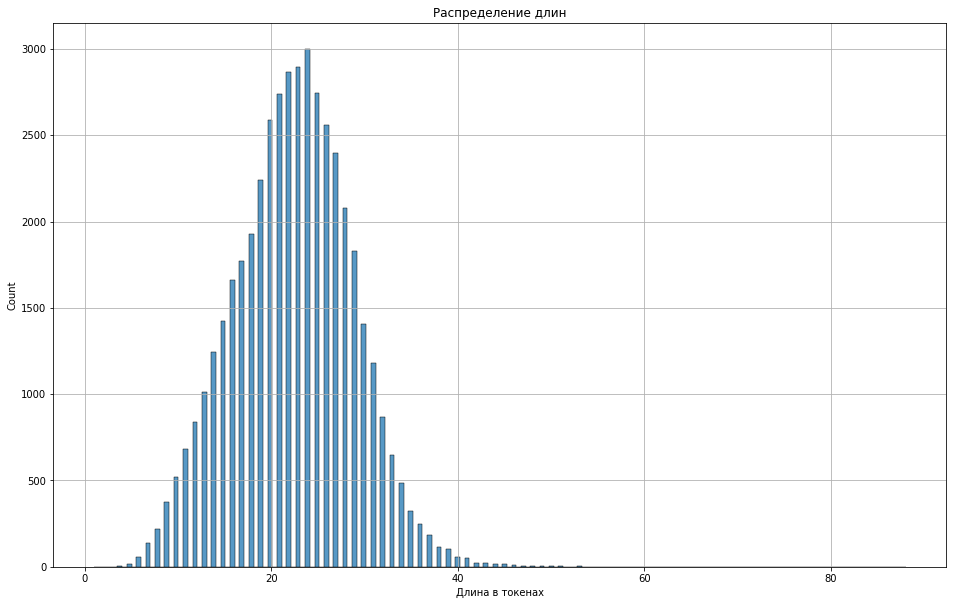

In [ ]:
plt.figure(figsize=(16, 10))
plt.grid()
plt.title("Распределение длин")
plt.xlabel("Длина в токенах")
sns.histplot(lengths)

In [ ]:
np.percentile(lengths, 95)

33.0

In [ ]:
class Tokenizer:
    
    def __init__(self, base_tokenizer, token2index, unk_token='UNK', pad_token='PAD', max_length=33):
        
        self._base_tokenizer = base_tokenizer  # например ToktokTokenizer()
        
        self.token2index = token2index  # словарь из load_embeddings()
        
        self.pad_token = pad_token
        self.pad_index = self.token2index[self.pad_token]
        
        self.unk_token = unk_token
        self.unk_index = self.token2index[self.unk_token]
        
        self.max_length = max_length

    def tokenize(self, text):
        """
        В этом методе нужно разделить строку текста на токены
        """
        x = self._base_tokenizer()
        tokenized_text = x.tokenize(text)
        return tokenized_text
    
    def indexing(self, tokenized_text):
        """
        В этом методе нужно перевести список токенов в список с индексами этих токенов
        """
        tokens_indices = []
        for token in tokenized_text:

          if token not in token2index:
            if tokens_indices.count(self.unk_index)< 1:
              tokens_indices.append(self.unk_index)
          else:
            token_index = token2index[token]
            tokens_indices.append(token_index)

        return tokens_indices
        
    def padding(self, tokens_indices):
        """
        В этом методе нужно сделать длину tokens_indices равной self.max_length
        Опционально убрать повторяющиеся unk'и
        """
        while len(tokens_indices)< self.max_length:
          tokens_indices.append(self.pad_index)
        return tokens_indices
        
    def __call__(self, text):
        """
        В этом методе нужно перевести строку с текстом в вектор с индексами слов нужно размера (self.max_length)
        """
        tokenized_text = self.tokenize(text)
        tokens_indices = self.indexing(tokenized_text)
        return self.padding(tokens_indices)
        
    def collate(self, batch):
        
        tokenized_texts = list()
        labels = list()
        
        for i in range(len(batch)):

          text = batch[i]['text']
          label = batch[i]['label']
          tokenized_text = self.__call__(text)
          tokenized_texts.append(tokenized_text)# список списков с паддингом
          labels.append(label)
        #print(tokenized_texts,'tokenized_texts')    
        tokenized_texts = torch.Tensor(tokenized_texts)  # перевод в torch.Tensor
        labels = torch.Tensor(labels)  # перевод в torch.Tensor
        #print(type(tokenized_texts))
        return tokenized_texts, labels

## Перед реализацией выбранного метода
Советую, чтобы в итоге `Loader` отдавал кортеж с двумя тензорами:
- `torch.Tensor` с индексами токенов, размерность `(batch_size, sequence_length)`
- `torch.Tensor` с индексами таргетов, размерность `(batch_size)`

То есть, чтобы было так:
```python
for x, y in train_loader:
    ...

>> x
>> tensor([[   37,  3889,   470,  ...,     0,     0,     0],
           [ 1509,   581,   144,  ...,     0,     0,     0],
           [ 1804,   893,  2457,  ...,     0,     0,     0],
           ...,
           [  170, 39526,  2102,  ...,     0,     0,     0],
           [ 1217,   172, 28440,  ...,     0,     0,     0],
           [   37,    56,   603,  ...,     0,     0,     0]])

>> y
>> tensor([1, 2, 2, 2, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 0, 1, 2, 0, 0, 1,
           0, 2, 1, 1, 0, 1, 2, 0, 2, 1, 2, 1, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 0,
           1, 0, 2, 2, 2, 1, 1, 2, 2, 2, 1, 2, 0, 1, 0, 2, 1, 2, 2, 1, 0, 0, 2, 2,
           2, 1, 2, 0, 2, 2, 0, 2, 0, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 2, 1, 0, 2, 2,
           2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 2, 2, 1, 2, 1,
           2, 1, 1, 2, 2, 1, 1, 2])

>> x.shape
>> torch.Size([128, 64])

>> y.shape
>> torch.Size([128])
```
При условии, что батч сайз равен 128, а максимальная длина последовательности равна 64.

## Помните

## <Место для реализации>

In [ ]:
x = Tokenizer(base_tokenizer=ToktokTokenizer, token2index=token2index,
              unk_token='UNK', pad_token='PAD', max_length=33)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=x.collate)
valid_loader = DataLoader(valid_dataset, batch_size=2, shuffle=False, collate_fn=x.collate)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, collate_fn=x.collate)

In [ ]:
for x, y in train_loader:
    break

[[1, 55, 73, 364, 403, 5, 77, 1938, 6, 1343, 3, 2148, 552, 15, 44617, 12, 57, 11536, 22, 48110, 30, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 890, 6, 230, 3, 360, 182, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]] tokenized_texts
<class 'torch.Tensor'>


In [ ]:
for x, y in train_loader:
  x = x.view(x.shape[0], -1)
  break

[[19, 1, 135, 19187, 2, 39, 13, 193, 30, 19, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 21, 1807, 12, 15012, 29, 22, 8, 320, 224, 9, 16, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]] tokenized_texts
<class 'torch.Tensor'>


In [ ]:
assert(isinstance(x, torch.Tensor))
assert(len(x.size()) == 2)

assert(isinstance(y, torch.Tensor))
assert(len(y.size()) == 1)

In [ ]:
x.view(x.shape[0], -1).numpy().shape

(2, 33)

# Реализация DAN

На вход модели будут подавать индексы слов

Шаги:
- Переводим индексы слов в эмбеддинги
- Усредняем эмбеддинги
- Пропускаем усредненные эмбеддинги через `Multilayer Perceptron`
    - Нужно реализовать самому
    
Дополнительно:
- Добавьте `nn.Dropout`, `nn.BatchNorm` по вкусу
- Сделайте усреднение с учетом падов
- Используйте эмбеддинги от берта/роберты/тд (когда-нибудь про это будет целый туториал, а пока предлагают вам попробовать сделать это самим)

# Советы

## До обучения
- Выберите метрику(ки) качества и расскажите почему она(они)
    - Обычно есть основная метрика, по которой принимаем решения какие веса брать и дополнительные, которые нам помогут делать выводы, например, о том все ли хорошо с нашими данными, хорошо ли модель справляется с дисбалансом классов и тд
- Эту домашку можно сделать и на `CPU`, но на `GPU` будет сильно быстрее
    - Во всех остальных домашках мы будем учить модели на `GPU`
    - Рано или поздно вам придется посмотреть этот [туториал](https://www.youtube.com/watch?v=pgk1zGv5lU4)
    - Вы можете обучаться на `colab`, это бесплатно

## До эпохи
- Сделайте списки/словари/другое, чтобы сохранять нужные данные для расчета метрик(и) по всей эпохе для трейна и валидации

## Во время эпохи
- Используйте [`tqdm`](https://github.com/tqdm/tqdm) как прогресс бар, чтобы понимать как проходит ваше обучение
- Логируйте лосс
- Логируйте метрику(ки) по батчу
- Сохраняйте то, что вам нужно, чтобы посчитать метрик(и) на всю эпоху для трейна и валидации

## После эпохи
- Посчитайте метрик(и) на всю эпоху для трейна и валидации

## После обучения
- Провалидируйтесь на тестовом наборе и посмотрите метрики
- Постройте [`classification_report`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)
- Постройте графики:
    - [Confusion Matrix](https://scikit-learn.org/stable/modules/model_evaluation.html#confusion-matrix)
    - [Опционально] Распределение вероятностей мажоритарного класса (то есть для какого-то примера мы выбираем такой класс и вероятность этого выбора такая-то) на трейне/тесте/валидации
        - Если класс был выбран верно и если была ошибка
- Подумайте что еще вам будет полезно для того, чтобы ответить на такие вопросы: 
    - Что в моделе можно улучшить?
    - Все ли хорошо с моими данными?
    - Все ли хорошо с валидацией?
    - Не переобучился ли я?
    - Достаточно ли я посмотрел на данные?
    - Нужно ли мне улучшить предобработку данных?
    - Нужно ли поменять токенизацию или эмбеддинги?
    - Нет ли у меня багов в реализации?
    - Какие типичные ошибки у моей модели?
    - Как я могу их исправить?

# Я выбрал метрику <МЕТРИКА>
Почему я выбрал эту метрику:  
<РАССКАЗ_ПРО_МЕТРИКУ>

In [ ]:
class DeepAverageNetwork(nn.Module):
  def __init__(self, in_features=33, inner_features=300, out_features=3):
        
        # Вызываем __init__ родителя - torch.nn.Module
        super().__init__()
        
        self.emb_layer = torch.nn.Embedding.from_pretrained(torch.Tensor(embeddings_matrix))
        self.linear_1 = torch.nn.Linear(in_features=in_features, out_features=inner_features)
        self.non_linear_function = torch.nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        self.linear_2 = torch.nn.Linear(in_features=inner_features, out_features=out_features)
        self.softmax = torch.nn.Softmax()

  def forward(self, x):
    # переводим индексы в эмбеддинги
    embeddings = self.emb_layer(x)
    # усредняем эмбеддинги 
    embeddings = torch.mean(embeddings,1,True)
      

    # прогоняем через multilayer perceptron
    result = self.linear_1(embeddings)
    result = self.dropout(self.non_linear_function(result))
    result = self.softmax(result)
    return result

Переводим индексы слов в эмбеддинги
Усредняем эмбеддинги
Пропускаем усредненные эмбеддинги через Multilayer Perceptron

In [ ]:
model = DeepAverageNetwork()

In [ ]:
model

DeepAverageNetwork(
  (emb_layer): Embedding(100000, 300)
  (linear_1): Linear(in_features=33, out_features=300, bias=True)
  (non_linear_function): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (linear_2): Linear(in_features=300, out_features=3, bias=True)
  (bnm5): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (softmax): Softmax(dim=None)
)

## Задайте функцию потерь и оптимизатор

In [ ]:
criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01)

## Сделайте цикл обучения

In [ ]:
epochs = 10
losses = []
best_test_loss = 10.

for n_epoch in range(epochs):
    
    train_losses = []
    test_losses = []
    test_preds = []
    test_targets = []
    
    progress_bar = tqdm(total=len(train_loader.dataset), desc='Epoch {}'.format(n_epoch + 1))
    
    for x, y in train_loader:
        
        x = x.view(x.shape[0], -1)
        y = y.unsqueeze(1).float()
        
        optimizer.zero_grad()
        
        pred = model(x.long())
        
        loss = criterion(pred, y.float())
        
        loss.backward()
        
        optimizer.step()
        
        train_losses.append(loss.item())
        losses.append(loss.item())
        
        progress_bar.set_postfix(train_loss = np.mean(losses[-100:]))

        progress_bar.update(x.shape[0])
        
    progress_bar.close()
    
    for x, y in test_loader:
        
        x = x.view(x.shape[0], -1)
        y = y.unsqueeze(1).float()

        with torch.no_grad():
            pred = model(x.long())
            
        test_preds.append(pred.numpy())
        test_targets.append(y.numpy())

        loss = criterion(pred, y)

        test_losses.append(loss.item())
        
    mean_test_loss = np.mean(test_losses)
        
    print('Losses: train - {:.3f}, test = {:.3f}'.format(np.mean(train_losses), mean_test_loss))
    
    test_preds = np.concatenate(test_preds)
    test_preds = test_preds.squeeze()
    test_targets = np.concatenate(test_targets).squeeze()
    
    test_preds[test_preds > 0.5] = 1
    test_preds[test_preds <= 0.5] = 0
    
    accurary = accuracy_score(test_targets, test_preds)

    print('Test: accuracy - {:.3f}'.format(accurary))
      
    if mean_test_loss < best_test_loss:
        best_test_loss = mean_test_loss
    else:
        print('Early stopping')
        break

Epoch 1:   0%|          | 0/45615 [07:34<?, ?it/s]

[[60, 1, 4725, 41, 3701, 9, 5931, 742, 5, 622, 6, 2592, 66, 14, 118, 73731, 50789, 21, 55, 102, 57, 3499, 3157, 1832, 30, 0, 0, 0, 0, 0, 0, 0, 0], [1, 10, 83, 26, 328, 26, 53, 50, 6, 39, 6, 9864, 21, 120, 9, 18, 5754, 181, 18, 15, 51, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]] tokenized_texts
<class 'torch.Tensor'>
torch.Size([2, 33, 300])


RuntimeError: ignored

In [ ]:
plt.figure(figsize=(14, 12))
plt.plot(losses)
plt.grid()
plt.title('Training process')
plt.xlabel('Iterations')
plt.ylabel('Loss function');

In [ ]:
print(classification_report(targets, (np.array(preds) > 0.5).astype(int)))

# Выводы
Напишите небольшой отчет о проделанной работе. Что удалось, в чем не уверены, что делать дальше.